In [1]:
#@title Importing libraries (double-click to show code)
import os
import pkg_resources
pkg_resources.require("numpy>=`1.20.1")  #  to use specific numpy version
import numpy as np
import rsnapsim as rss
import sys
from sys import platform
from skimage import io ; from skimage.io import imread; from skimage.measure import find_contours
from random import randrange
import pandas as pd
import os; from os import listdir; from os.path import isfile, join
import re
import shutil
import pathlib
from random import randrange
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout 
from IPython.display import Image
import dna_features_viewer
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord, CircularGraphicRecord

# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.grid'] = False


In [2]:
# Plasmid sequences
gene_file_pUB_SM_KDM5B_PP7 = str(sequences_dir.joinpath('pUB_SM_KDM5B_PP7.gb')) # plasmid pUB_SM_KDM5B_PP7 
gene_file_pUB_SM_p300_MS2 = str(sequences_dir.joinpath('pUB_SM_p300_MS2.gb')) # plasmid pUB_SM_p300_MS2

# Coding sequence
gene_file_KDM5B_PP7 = str(sequences_dir.joinpath('pUB_SM_KDM5B_PP7_coding_sequence.txt')) # coding sequence for SM_KDM5B_PP7    ### 5685 nt   ### 1895 codons
gene_file_p300_MS2 = str(sequences_dir.joinpath('pUB_SM_p300_MS2_coding_sequence.txt'))  # coding sequence for SM_p300_MS2      ### 8268 nt   ### 2756 codons

In [3]:
from dna_features_viewer import BiopythonTranslator
class MyCustomTranslator(BiopythonTranslator):
    """Custom translator
    """
    def compute_feature_color(self, feature):
        if feature.type == "CDS":
            return "#57B956"
        elif feature.type == "FLAG":
            return "#57B956"
        elif feature.type == "MS2":
            return "#098BF5"
        elif feature.type == "PP7": 
            return "#EB5559"
        else:
            return "#C4B07B"

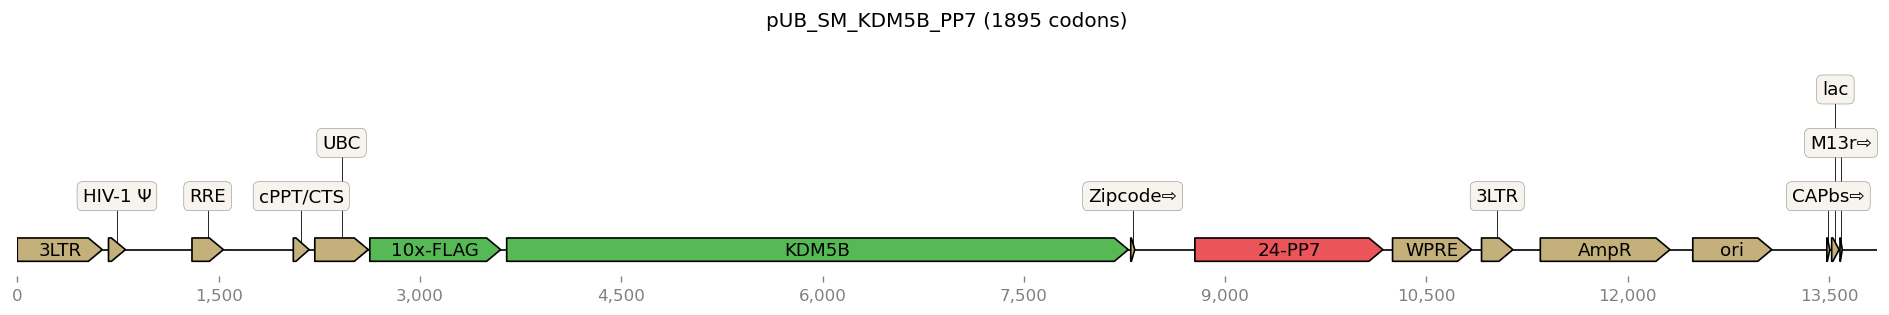

In [4]:
graphic_record = MyCustomTranslator().translate_record(gene_file_pUB_SM_KDM5B_PP7) 
ax, _ = graphic_record.plot(figure_width=20, strand_in_label_threshold=7)
ax.set_title('pUB_SM_KDM5B_PP7 (1895 codons)')
graphic_record.plot_legend(ax=ax, loc=1, ncol=3, frameon=False)
ax.figure.savefig("pUB_SM_KDM5B_PP7.png")

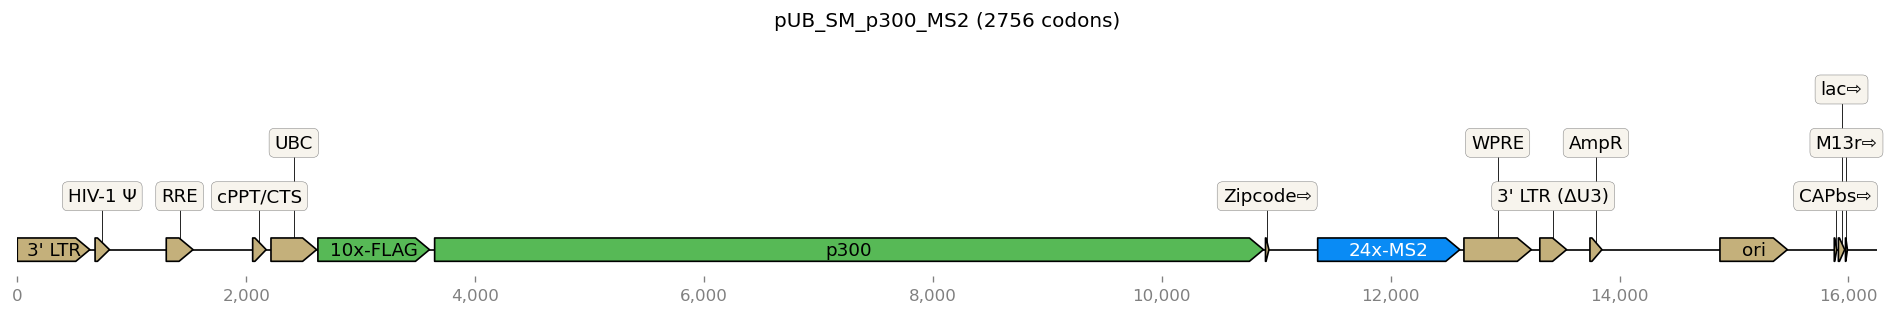

In [5]:
graphic_record = MyCustomTranslator().translate_record(gene_file_pUB_SM_p300_MS2) 
ax, _ = graphic_record.plot(figure_width=20, strand_in_label_threshold=7)
ax.set_title('pUB_SM_p300_MS2 (2756 codons)')
graphic_record.plot_legend(ax=ax, loc=1, ncol=3, frameon=False)
ax.figure.savefig("pUB_SM_p300_MS2.png")

In [6]:
list_files_names = sorted([f for f in listdir(video_dir) if isfile(join(video_dir, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
num_cell_shapes = len(path_files)

In [7]:
# proteins with Cy3 (green), PP7 with JF646 (red), and MS2 with GFP (blue).

In [8]:
# Inputs
list_gene_sequences = [gene_file_KDM5B_PP7, gene_file_p300_MS2] # path to gene sequences
list_number_spots = [25, 25] # list of integers, where each element represents the number of spots

list_target_channels_proteins = [1, 1] # channel where the simulated protein spots will be located. Integer between 0 and 2. 

list_target_channels_mRNA = [0, 2] # channel where the simulated mRNA spots will be located. Integer between 0 and 2. 

list_diffusion_coefficients =[0.5, 0.5] # diffusion coefficients for each gene
list_label_names = ['kdm5b','p300'] # list of strings used to generate a classification field in the output data frame

list_elongation_rates = [10, 10] # elongation rates aa/sec
list_initation_rates = [0.03, 0.03] # initiation rates 1/sec
frame_selection_empty_video = 'shuffle' # Options are: 'constant' , 'shuffle' and 'loop'

simulation_time_in_sec = 1000

step_size_in_sec = 1
save_as_tif = 1 # option to save the simulated video
save_dataframe = 1 # option to save the simulation output as a dataframe in format csv. 
create_temp_folder = 1 # saves the video and data frame in a temp folder

spot_size = 3 # size of spots in pixels

In [9]:
# Number of simulated Cell
number_cells = 5

In [10]:
list_dataframe_simulated_cell =[]
list_ssa_all_cells_and_genes =[]
list_videos =[]
for i in range (0,number_cells ):
    saved_file_name = 'cell_' + str(i)  # if the video or dataframe are save, this variable assigns the name to the files
    sel_shape = randrange(num_cell_shapes)
    video_path = path_files[sel_shape]
    inial_video = io.imread(video_path) # video with empty cell
    
    tensor_video, single_dataframe_simulated_cell, list_ssa = rsp.SimulatedCellMultiplexing(inial_video,list_gene_sequences,list_number_spots,list_target_channels_proteins,list_target_channels_mRNA, list_diffusion_coefficients,list_label_names,list_elongation_rates,list_initation_rates,simulation_time_in_sec,step_size_in_sec,save_as_tif, save_dataframe, saved_file_name,create_temp_folder,cell_number =i,frame_selection_empty_video=frame_selection_empty_video,spot_size =spot_size).make_simulation()
    
    list_dataframe_simulated_cell.append(single_dataframe_simulated_cell)
    list_ssa_all_cells_and_genes.append(list_ssa)
    list_videos.append(tensor_video)

The output is saved in the directory:  /home/luisub/Desktop/rsnaped/notebooks/Machine_Learning/temp
The output is saved in the directory:  /home/luisub/Desktop/rsnaped/notebooks/Machine_Learning/temp
The output is saved in the directory:  /home/luisub/Desktop/rsnaped/notebooks/Machine_Learning/temp
The output is saved in the directory:  /home/luisub/Desktop/rsnaped/notebooks/Machine_Learning/temp
The output is saved in the directory:  /home/luisub/Desktop/rsnaped/notebooks/Machine_Learning/temp
The output is saved in the directory:  /home/luisub/Desktop/rsnaped/notebooks/Machine_Learning/temp
The output is saved in the directory:  /home/luisub/Desktop/rsnaped/notebooks/Machine_Learning/temp
The output is saved in the directory:  /home/luisub/Desktop/rsnaped/notebooks/Machine_Learning/temp
The output is saved in the directory:  /home/luisub/Desktop/rsnaped/notebooks/Machine_Learning/temp
The output is saved in the directory:  /home/luisub/Desktop/rsnaped/notebooks/Machine_Learning/temp


In [11]:
dataframe_simulated_cell = pd.concat(list_dataframe_simulated_cell)

In [12]:
dataframe_simulated_cell

,cell_number,particle,frame,red_int_mean,green_int_mean,blue_int_mean,red_int_std,green_int_std,blue_int_std,x,y,Classification
0,0,0,0,33.279999,26.200001,0.000000,63.024770,25.692022,30.511794,180.0,352.0,kdm5b
1,0,0,1,29.480000,17.400000,10.640000,55.388172,34.610981,41.318161,178.0,352.0,kdm5b
2,0,0,2,47.380001,8.900000,0.000000,61.394671,28.646815,30.589828,178.0,352.0,kdm5b
3,0,0,3,29.760000,27.440001,0.000000,66.912648,25.609498,30.589828,178.0,352.0,kdm5b
4,0,0,4,31.719999,23.120001,4.080000,51.575591,29.861440,28.769317,178.0,352.0,kdm5b
...,...,...,...,...,...,...,...,...,...,...,...,...
24995,4,49,995,30.440001,15.460000,26.240000,73.371973,39.934426,55.982340,365.0,171.0,p300
24996,4,49,996,0.000000,26.320000,17.840000,48.236517,35.665917,54.546626,366.0,172.0,p300
24997,4,49,997,21.400000,27.840000,31.200001,67.512369,36.991545,56.720367,366.0,172.0,p300
24998,4,49,998,11.160000,23.040001,28.240000,52.844436,51.971900,56.317159,366.0,171.0,p300


In [13]:
num_videos =len(list_videos)
num_videos

5

In [14]:
selected_cel =0
selected_gene = 0 #kdm5b
# time points in ssa
nuber_ssa_trajectories = list_ssa_all_cells_and_genes[selected_cel][selected_gene].shape[0]
number_tp = list_ssa_all_cells_and_genes[selected_cel][selected_gene].shape[1]
nuber_ssa_trajectories, number_tp

(25, 1000)

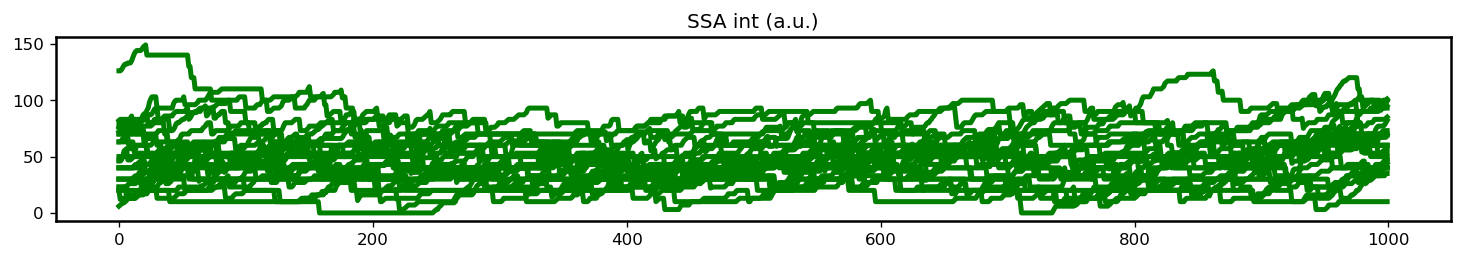

In [32]:
plt.figure(figsize=(15,2))
for tr in range(0,nuber_ssa_trajectories ):
    plt.plot(list_ssa_all_cells_and_genes[selected_cel][selected_gene][tr] , '-',linewidth = 3,color='green')
plt.title('SSA int (a.u.)')
plt.show()

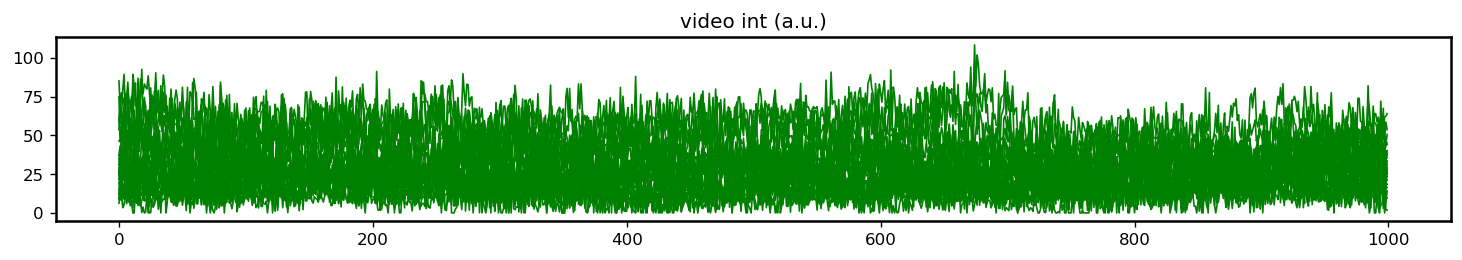

In [35]:
plt.figure(figsize=(15,2))
for i in range(0,len(list_gene_sequences)):
    for j in range (0,list_number_spots[i]):
        if i >0:
            spot_num_counter = j + list_number_spots[0]
        else:
            spot_num_counter = j
        sim_cell_int_traj = dataframe_simulated_cell.loc[   (dataframe_simulated_cell['Classification']=='kdm5b') & (dataframe_simulated_cell['particle']==spot_num_counter) & (dataframe_simulated_cell['cell_number']==selected_cel)  ].green_int_mean.values
        if sim_cell_int_traj.any():
            plt.plot (sim_cell_int_traj ,linewidth = 1,color='green' )      
plt.title('video int (a.u.)')
plt.show()

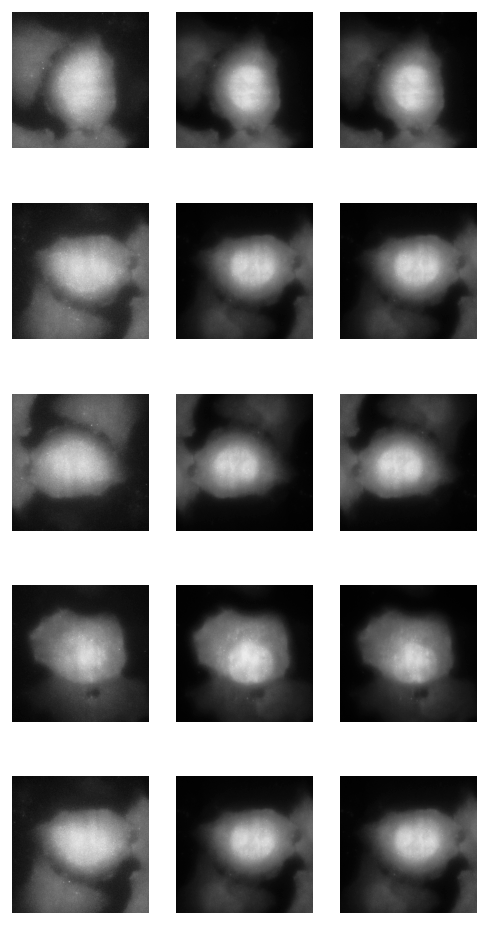

In [37]:
# In this section of the code we will plot the videos for all cells using a for loop. 
# in the plot each row represents a cell and the columns represent the color channel.
selected_timePoint = 0 # selecting a frame to display in the plot.

fig, ax = plt.subplots(num_videos,3, figsize=(5, num_videos*2))
for i in range(0,num_videos):
  ax[i,0].imshow(list_videos[i][selected_timePoint,:,:,0],cmap='Greys_r')
  ax[i,1].imshow(list_videos[i][selected_timePoint,:,:,1],cmap='Greys_r')
  ax[i,2].imshow(list_videos[i][selected_timePoint,:,:,2],cmap='Greys_r')
  ax[i,0].axis('off')
  ax[i,1].axis('off')
  ax[i,2].axis('off')
plt.show()

In [ ]:
from matplotlib import animation
from IPython.display import HTML
def make_movie(image_tensor, cmaps = ['Reds_r','Greens_r','Blues_r'], channels = True):
  '''
  returns an ipython.html obj to display an image tensor
  '''
  if channels:  # if channels = True we will make a 3 color / 3 plot movie
    fig,axes = plt.subplots(1,3,figsize=(15, 7),tight_layout=True,)
  else: # otherwise just one subplot is needed
    fig,axes = plt.subplots(1,1,figsize=(15, 7),tight_layout=True,) #tight layout sets the axis's apart
  #fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
  if channels: #if channels set up inital images here
    im1 = axes[0].imshow(image_tensor[0,:,:,0], cmap=cmaps[0])  #get blank axes.image objects to maniuplate later
    im2 = axes[1].imshow(image_tensor[0,:,:,1], cmap=cmaps[1])
    im3 = axes[2].imshow(image_tensor[0,:,:,2], cmap=cmaps[2])
    for k in range(3):
      axes[k].set_title('Channel %i'%k)
  else:
    im1 = axes.imshow(image_tensor[0,:,:,:], cmap=cmaps[0]) #if merge just make one
    axes.set_title('Merge')
  plt.close()

  #here set up the function that is called by FuncAnimation, it returns the artist objects and updates the frame by i
  def movieFrame(i):
    ## Extract all the image channels
    #Define  frames
    if channels:  #get the channels if 3 color
      channel_1_img = image_tensor[i,:,:,0]
      channel_2_img = image_tensor[i,:,:,1]
      channel_3_img = image_tensor[i,:,:,2]
      images = [channel_1_img, channel_2_img, channel_3_img]  # concatenate channels
      axes_handles = [im1,im2,im3]  #Axes handles from the imshow
    else:
      channel_img = image_tensor[i,:,:,:]   
      images = [channel_img,]  # concatenate channels
      axes_handles = [im1,]  #Axes handles from the imshow

    #update the axes imshow objects with the new data per k channels
    for k,image_n in enumerate(images):  #for loop that returns an object and an index
      axes_handles[k].set_array(images[k])  # 
    return axes_handles  #return the object
  
  #here call the animation function from matplotlib and then return the final HTML video object to the user
  anim = animation.FuncAnimation(fig, movieFrame, frames=image_tensor.shape[0], interval=100, blit=True)
  return HTML(anim.to_html5_video())

In [ ]:
if 0:
    make_movie(list_videos[1])